In [1]:
pip install tensorflow matplotlib pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import os
import matplotlib.pyplot as plt


In [27]:

# Dataset path
dataset_path = "C://Users//USER//Desktop//posture_model_dataset"  # Update with the actual dataset path

# Image size and batch size
image_size = (224, 224)
batch_size = 32

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% training, 20% validation
)

# Training data
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Multi-class classification
    subset='training'
)

# Validation data
val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Multi-class classification
    subset='validation'
)

# Print class indices
print("Posture Classes:", train_data.class_indices)


Found 242 images belonging to 4 classes.
Found 58 images belonging to 4 classes.
Posture Classes: {'computer_postures': 0, 'household_postures': 1, 'yoga_sitting_postures': 2, 'yoga_standing_postures': 3}


In [29]:
def multi_output_generator(generator):
    for batch_x, batch_y in generator:
        # Binary labels for correctness based on filenames
        correctness_y = np.array([1 if "incorrect" in path else 0 for path in generator.filepaths])
        correctness_y = correctness_y[:len(batch_y)]  # Ensure batch size consistency

        # Yield inputs and outputs
        yield batch_x, {
            "posture_output": batch_y,           # Multi-class labels
            "correctness_output": correctness_y  # Binary labels
        }


In [31]:
# Load MobileNetV2 as the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add global average pooling
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

# Posture classification output (multi-class)
posture_output = Dense(len(train_data.class_indices), activation='softmax', name='posture_output')(x)

# Correctness prediction output (binary)
correctness_output = Dense(1, activation='sigmoid', name='correctness_output')(x)

# Define the model
model = Model(inputs, outputs=[posture_output, correctness_output])

# Compile the model
model.compile(
    optimizer='adam',
    loss={
        "posture_output": "categorical_crossentropy",
        "correctness_output": "binary_crossentropy"
    },
    metrics={
        "posture_output": "accuracy",
        "correctness_output": "accuracy"
    }
)

# Model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_3[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ posture_output      │ (None, 4)         │      5,124 │ global_average_p… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ correctness_output  │ (None, 1)         │      1,281 │ global_average_p… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
# Wrap data generators
train_generator = multi_output_generator(train_data)
val_generator = multi_output_generator(val_data)

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_multi_output_model.keras', save_best_only=True)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=train_data.samples // batch_size,
    validation_steps=val_data.samples // batch_size,
    callbacks=callbacks
)


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - correctness_output_accuracy: 0.6694 - correctness_output_loss: 0.6549 - loss: 2.1537 - posture_output_accuracy: 0.3348 - posture_output_loss: 1.4988 - val_correctness_output_accuracy: 0.0625 - val_correctness_output_loss: 1.7151 - val_loss: 2.8269 - val_posture_output_accuracy: 0.4688 - val_posture_output_loss: 1.1118
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - correctness_output_accuracy: 0.6663 - correctness_output_loss: 0.6989 - loss: 1.8261 - posture_output_accuracy: 0.5646 - posture_output_loss: 1.1522 - val_correctness_output_accuracy: 0.2812 - val_correctness_output_loss: 1.0702 - val_loss: 1.9447 - val_posture_output_accuracy: 0.7500 - val_posture_output_loss: 0.8745
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - correctness_output_accuracy: 0.6631 - correctness_output_loss: 0.6342 - loss: 1.5764 - posture_output_accuracy: 0.5980 - posture_output_loss: 0.9545 - val_correctness_output_accuracy: 0.0625 - val_correctness_out

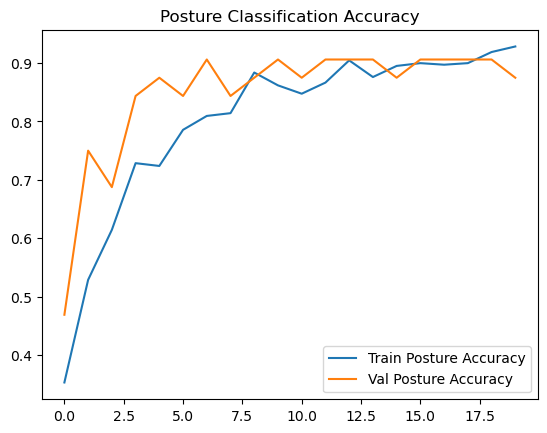

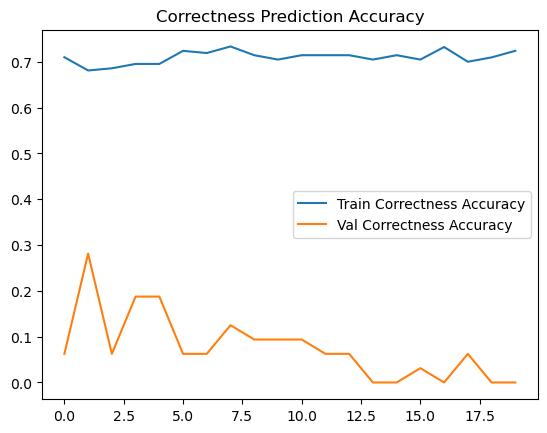

In [35]:
# Posture classification accuracy
plt.plot(history.history['posture_output_accuracy'], label='Train Posture Accuracy')
plt.plot(history.history['val_posture_output_accuracy'], label='Val Posture Accuracy')
plt.legend()
plt.title('Posture Classification Accuracy')
plt.show()

# Correctness prediction accuracy
plt.plot(history.history['correctness_output_accuracy'], label='Train Correctness Accuracy')
plt.plot(history.history['val_correctness_output_accuracy'], label='Val Correctness Accuracy')
plt.legend()
plt.title('Correctness Prediction Accuracy')
plt.show()


In [37]:
from tensorflow.keras.preprocessing import image

# Load the saved model
model = tf.keras.models.load_model('best_multi_output_model.keras')

# Path to the new image
img_path = "D://Downloads//standing.jpg"  # Update with the actual path
img = image.load_img(img_path, target_size=image_size)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make predictions
predictions = model.predict(img_array)

# Extract predictions
posture_pred = np.argmax(predictions[0], axis=1)  # Multi-class prediction
correctness_pred = (predictions[1] > 0.5).astype(int)  # Binary prediction

# Map predictions to labels
posture_labels = list(train_data.class_indices.keys())
print("Predicted Posture Class:", posture_labels[posture_pred[0]])
print("Correctness Prediction:", "Correct" if correctness_pred[0][0] == 0 else "Incorrect")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
Predicted Posture Class: yoga_standing_postures
Correctness Prediction: Incorrect


In [39]:
from tensorflow.keras.preprocessing import image

# Load the saved model
model = tf.keras.models.load_model('best_multi_output_model.keras')

# Path to the new image
img_path = "D://Downloads//images.jpg"  # Update with the actual path
img = image.load_img(img_path, target_size=image_size)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make predictions
predictions = model.predict(img_array)

# Extract predictions
posture_pred = np.argmax(predictions[0], axis=1)  # Multi-class prediction
correctness_pred = (predictions[1] > 0.5).astype(int)  # Binary prediction

# Map predictions to labels
posture_labels = list(train_data.class_indices.keys())
print("Predicted Posture Class:", posture_labels[posture_pred[0]])
print("Correctness Prediction:", "Correct" if correctness_pred[0][0] == 0 else "Incorrect")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Posture Class: yoga_sitting_postures
Correctness Prediction: Incorrect


In [41]:
from tensorflow.keras.preprocessing import image

# Load the saved model
model = tf.keras.models.load_model('best_multi_output_model.keras')

# Path to the new image
img_path = "D://Downloads//posture-concept-young-woman-working-600nw-609986825.jpg"  # Update with the actual path
img = image.load_img(img_path, target_size=image_size)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make predictions
predictions = model.predict(img_array)

# Extract predictions
posture_pred = np.argmax(predictions[0], axis=1)  # Multi-class prediction
correctness_pred = (predictions[1] > 0.5).astype(int)  # Binary prediction

# Map predictions to labels
posture_labels = list(train_data.class_indices.keys())
print("Predicted Posture Class:", posture_labels[posture_pred[0]])
print("Correctness Prediction:", "Correct" if correctness_pred[0][0] == 0 else "Incorrect")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
Predicted Posture Class: computer_postures
Correctness Prediction: Incorrect
